# Computing NLO Phase Shifts in Coordinate Space

We have seen that computing NLO phase shifts at large Lambda = 2/R values is numerically difficult – presumably because of the Fourier transform. We will try and bypass those issues by doing the calculation entirely in coordinate space.

The $t$-matrix amplitude is approximated as
$$
t = t^{(0)} + t^{(1)}
$$
We're going to consider the Born approximation for $t^{(1)}$,
$$
t^{(1)} \approx -\frac{2\mu}{k} \langle \phi^{(0)} | V_{\rm NLO} | \phi^{(0)} \rangle
$$

(Is this the DWBA?)

We need $\phi^{(0)}$, and we need it properly/consistently **normalized**. Then we need to compute the integral. Finally, we'll (carefully) extract the phase shift via
$$
e^{2i\delta} = S = 1 - 2it
$$

Steps:

1. Compute $\phi^{(0)}$.
2. Compute $\delta^{(0)}$ (compare to previous results).
3. Normalize $\phi^{(0)}$. (???)
4. Compute $t^{(0)} = e^{i\delta^{(0)}}\sin\delta^{(0)}$
5. Compute the phase shift correction ($\epsilon$), i.e. the matrix element, $\langle \phi^{(0)} | V_{\rm NLO} | \phi^{(0)} \rangle$, and add to $\delta^{(0)}$.

In [1]:
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy import optimize
from tqdm import tqdm
from multiprocess import Pool

from finite_differences import second_order_deriv
from interaction import regulator
from counterterm import local_LO_counterterm
from constants import MU, BETA4, C4
from utility import log_mesh
from free_solutions import phi_free, H_minus, H_minus_prime, H_plus, H_plus_prime

plt.style.use('science')
ratio = 4/3
h = 3

Read in RG flows (LO and NLO) and LO results.

In [2]:
rgf = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
rgf_nlo = np.loadtxt('rgflow_local_nlo_a0_B6_fix_coord_hp_n_14_coord_ir_corrected.txt')

deltas_lo = np.loadtxt('phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt')
ks_lo = deltas_lo[:, 0]
deltas_lo = deltas_lo[:, 1:].T

At what energies/momenta are we going to compute the phase shifts?

In [3]:
np.sqrt(1e5)

316.22776601683796

In [5]:
ks = np.logspace(np.log10(100/BETA4), np.log10(317/BETA4), 50)
energies = ks**2/(2*MU)

In [11]:
def v4(r):
        if r == 0:
            return 0
        else:
            return -C4/r**4


def construct_potential(R, c0):
    return lambda r: regulator(r, R)*v4(r) + c0*local_LO_counterterm(r, R)


rho_limits = np.array([140, 150])

def wave_function(v_r, energy, rho_endpts=np.array([0, rho_limits[1]])):
    k = np.sqrt(2*MU*energy)
    v_tilde = lambda rho: v_r(rho/k)/energy
    sol = solve_ivp(
        lambda rho, phi: [phi[1], (v_tilde(rho) - 1) * phi[0]], rho_endpts, [0, 1/k],
        rtol=1e-12, atol=1e-30,
        dense_output=True, method='DOP853', first_step=1e-12
    )
    return sol.sol

In [12]:
def phase_shift(u, up, ell, x0):
    rl = 1/x0 * (u/up)
    return np.log(
        (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
        (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
    ) / 2j


def delta(sol, k, max_rel_diff=1e-6, num_pts=1000):
    rhos = np.linspace(0.1, 4*np.pi, num_pts)
    w, wp = sol(rhos)
    y = phase_shift(w, wp, 0, rhos).real
    rel_diff = np.abs((y[1:] - y[:-1])/y[:-1])
    indices = np.where(rel_diff < max_rel_diff)[0]
    if len(indices) > 0:
        index = indices[0]
    else:
        index = np.argmin(rel_diff)
    return y[index], rhos[index], rel_diff[index]


def delta2(sol, k):
    rhos = np.linspace(*rho_limits, 1000)
    u = sol(rhos)[0]
    u /= np.max(np.abs(u))
    
    result = optimize.minimize(lambda x: np.sum((u + np.sin(rhos + x + np.pi))**2), 0.1)
    return result.x[0]

In [13]:
def norm_factors(u, delta0):
    rho_max_amp = np.pi/2 + 8*np.pi - delta0
    return np.abs(u(rho_max_amp)[0]) # / (np.sqrt(2/np.pi))


def norm_factors2(u, delta0):
    return np.max(np.abs(u(np.linspace(*rho_limits, 1000))[0]))


def matrix_element(phi_f, R):
    f = lambda r: phi_f(r)**2 * local_LO_counterterm(r, R)
    result = quad(f, 1e-4, 2*R, epsrel=1e-12, epsabs=1e-14, limit=200)
    return result[0]


def matrix_element2(sol, nf, k, R):
    f = lambda r: (sol(k*r)[0]/nf)**2 * local_LO_counterterm(r, R)
    result = quad(f, 1e-4, 2*R, epsrel=1e-12, epsabs=1e-14, limit=200)
    return result[0]

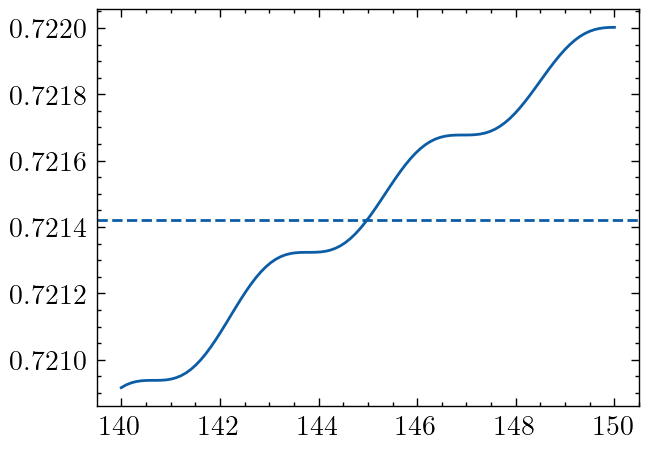

In [14]:
index = -1
R, c0, c2 = rgf_nlo[index]
pot = construct_potential(R, c0)

ie = 49
en = energies[ie]
k = ks[ie]
sol = wave_function(pot, en)

rhos = np.linspace(*rho_limits, 100)

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.axhline((delta2(sol, k) + np.pi) % np.pi, linestyle='--')
ax.plot(rhos, (phase_shift(*sol(rhos), 0, rhos).real + np.pi) % np.pi);
# ax.plot(rhos, sol(rhos).T);

In [15]:
d0 = delta2(sol, k)
nf = norm_factors2(sol, d0)

In [16]:
d0

-2.4201726400617463

In [17]:
-2*MU/k * c2 * en * matrix_element(lambda r: sol(k*r)[0]/nf, R)

21.548774192458133

In [18]:
-2*MU/k * c2 * en * matrix_element2(sol, nf, k, R)

21.548774192458133

In [19]:
@dataclass
class NLOResult:
    R: float
    c0: float
    c2: float
    lo_solutions: list
    momenta: np.array
    deltas_lo: np.array
    deltas_lo_err: np.array
    epsilons: np.array
    norm_facts: np.array
        
    def deltas_nlo(self):
        return self.deltas_lo + self.epsilons

In [20]:
nlo_results = []

for (R, c0, c2) in tqdm(rgf_nlo):
    pot = construct_potential(R, c0)
    f = lambda en: wave_function(pot, en)
    
    with Pool(4) as pool:
        solutions = pool.map(f, energies)
    
    d0s = np.array([delta2(sol, k) for (sol, k) in zip(solutions, ks)])
    nfs = np.array([norm_factors2(sol, d0) for (sol, d0) in zip(solutions, d0s)])

    mes = -2*MU/ks * c2 * energies * np.array(
        [matrix_element2(sol, nf, k, R) for (sol, nf, k) in zip(solutions, nfs, ks)]
    )
    mes1 = mes*np.exp(2j*d0s)

    eps = mes1 * np.exp(-2j*d0s)
    nlo_results.append(NLOResult(R, c0, c2, solutions, ks, d0s, None, eps, nfs))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [05:33<00:00,  4.22s/it]


In [21]:
# ii = np.where(phase_shift_info[:, 2] < 1e-8)[0]

In [22]:
# np.max(np.abs(np.array([res.deltas_lo_err for res in nlo_results]) / np.array([res.deltas_lo for res in nlo_results])))

In [23]:
deltas_mm = np.loadtxt('phase_shifts_mott_massey_wide_dense_coord_ir_corrected.txt')
ks_mm = deltas_mm[:, 0]
deltas_mm = deltas_mm[:, 1]

In [24]:
np.array([np.arctan(np.tan(res.deltas_lo)) for res in nlo_results]).shape

(79, 50)

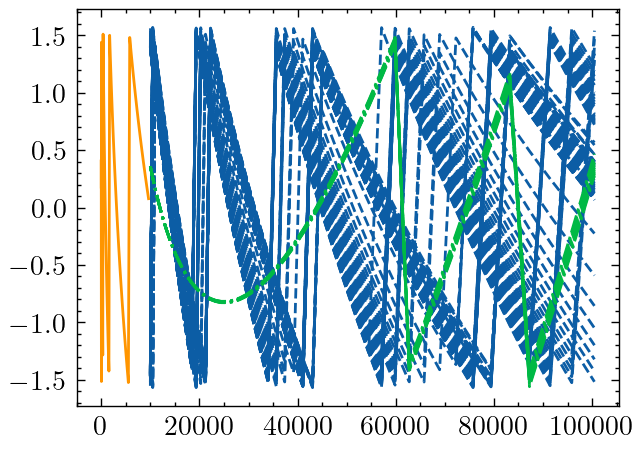

In [35]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks_mm*BETA4)**2, deltas_mm, color='C2');

ax.plot(
    (ks*BETA4)**2, 
    np.array(
        [np.arctan(np.tan(res.deltas_lo)) for res in nlo_results]
    ).T, color='C0', linestyle='--'
);

ax.plot(
    (ks*BETA4)**2, 
    np.array(
        [np.arctan(np.tan(res.deltas_nlo())).real for res in nlo_results[-10:]]
    ).T, color='C1', linestyle='-.'
);

# ax.plot((ks_lo*BETA4)**2, deltas_lo[-1], color='C3');

# ax.set_xscale('log')
# ax.set_yscale('log');

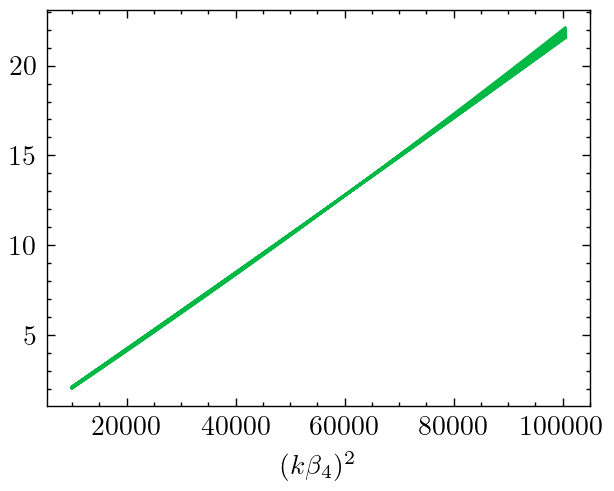

In [26]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(
    (ks*BETA4)**2, 
    np.array(
        [res.epsilons.real for res in nlo_results[50:]]
    ).T, color='C1', linestyle='-'
);

# ax.set_xscale('log')
ax.set_xlabel(r'$(k\beta_4)^2$');
# ax.set_ylabel(r'$\epsilon$');
# ax.set_yscale('log');

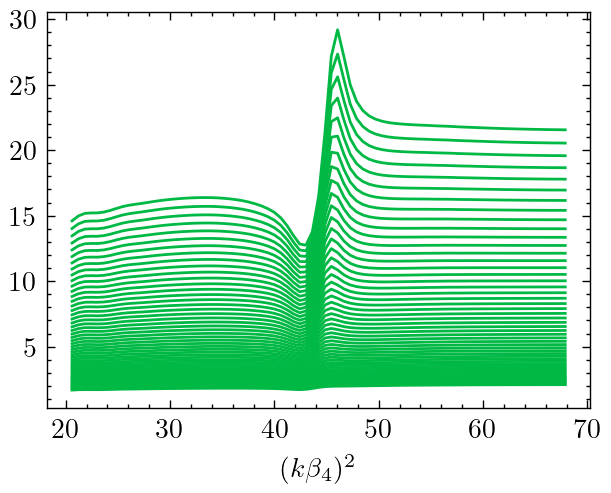

In [27]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(
    BETA4/rgf_nlo[:, 0], 
    np.array(
        [res.epsilons.real for res in nlo_results]
    ), color='C1', linestyle='-'
);

# ax.set_xscale('log')
ax.set_xlabel(r'$(k\beta_4)^2$');
# ax.set_ylabel(r'$\epsilon$');
# ax.set_yscale('log');

In [28]:
deltas = np.array([np.arctan(np.tan(res.deltas_nlo())) for res in nlo_results])

In [29]:
# np.savetxt('phase_shifts_fancy_pert_nlo_pert1_wide_dense_hp_n_14_true_coord_ir_corrected_high_energy.txt',
#            np.vstack((ks, deltas)).T)

In [30]:
Delta = 5*np.pi

def find_minus_to_plus(x):
    n = x.size
    indices = []
    for i in range(n-1):
        if np.sign(x[i]) == -1 and  np.sign(x[i+1]) == 1:
            indices.append(i+1)
    return indices

def shift(x, add_pi=False):
    xp = x.copy()
    indices = find_minus_to_plus(xp)
    i = 0
    s = 0
    for j in indices:
#         print(i, j, s)
        xp[i:j] -= s*np.pi
        s += 1
        i = j
    xp[j:] -= s*np.pi
    return xp + (Delta if add_pi else 0)

In [31]:
mm = shift(deltas_mm, True)
lo = shift(np.arctan(np.tan(nlo_results[-1].deltas_lo)), True)
nlo = shift(np.arctan(np.tan(nlo_results[-1].deltas_nlo())), True)

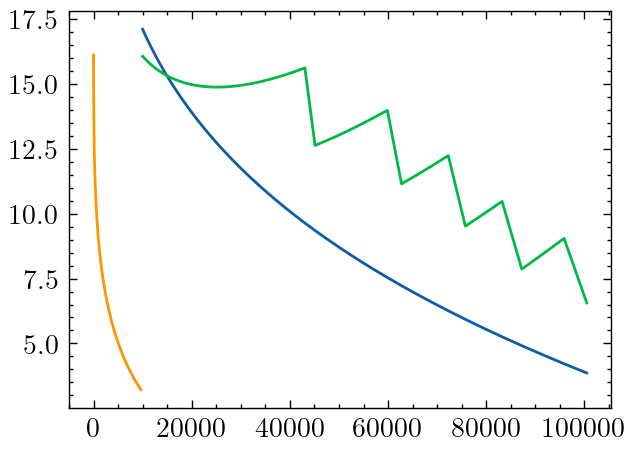

In [32]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, lo)
ax.plot((ks*BETA4)**2, nlo.real)
ax.plot((ks_mm*BETA4)**2, mm)

# ax.set_xscale('log')
# ax.set_yscale('log');

ValueError: operands could not be broadcast together with shapes (50,) (100,) 

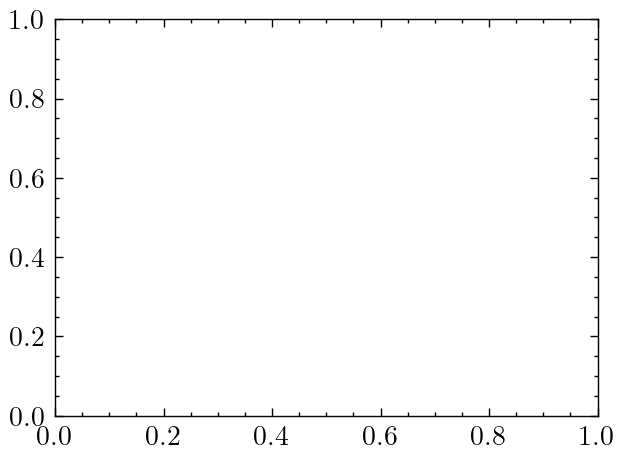

In [33]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, np.abs((lo/mm) - 1))
ax.plot((ks*BETA4)**2, np.abs((nlo.real/mm) - 1))

ax.set_xlim([10, 1e4])
ax.set_xscale('log')
ax.set_yscale('log');

In [ ]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, np.abs((lo - mm)/mm))
ax.plot((ks*BETA4)**2, np.abs((nlo.real - mm)/mm))

ax.set_xscale('log')
# ax.set_ylim([-0.5, 0.5])
ax.set_xlim([10, 10000])
ax.set_yscale('log');